In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import collections
# This allows chinese characters to show up in figures. 
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})

### Variables

In [80]:

######
##Variables
data_path = {'2016':'./data/2016Attendees.csv','2017':'./data/2017Attendees.csv'} 
#Extract target contents for different years:
useful_col_rename = {'2016':[(7,'paid date'),(10,'nationality'),(11,'gender'),(12,'company'),(13,'job_title')],
                     '2017':[(6,'paid date'),(9,'nationality'),(10,'gender'),(11,'company'),(12,'job_title')]}


### Functions

In [152]:
# Merge one type of datas with different years into a dataframe
def merge_valuecount(column_name,df_dict): #e.g. merge('gender',data_dict)
    count_list=[]
    for year in df_dict:
        tmp_count = pd.DataFrame(df_dict[year][column_name].value_counts())
        tmp_count.rename(index=str,columns={column_name:year},inplace=True)
        count_list.append(tmp_count)
    return pd.concat(count_list,sort=True,axis=1)

In [208]:
def merge_for_plot(column_name,df_dict):
    tmp_list=[]
    for year in df_dict:
        for i in range(len(df_dict[year][column_name])):
            tmp_list.append((year,df_dict[year][column_name][i]))
    return tmp_list

In [81]:
# Build a function to categorize attendees with job titles and company names
def cat_job(data):
    title = str(data['job_title'])
    company = str(data['company'])
    
    ## job title pattern dictionary
    # The first listed will be categorized last, so there is an ascending priority here
    pd_title = collections.OrderedDict()
    pd_title['freelancer'] = "(?i)self[ -]employed|freelancer"
    pd_title['consultant'] = "(?i)consultant|顧問"
    pd_title['other manager'] = "(?i)manager|C.O|supervisor|PM|founder|經理|.*長$|總裁|管理師|創辦人"
    # to be fixed: I failed to detect 'xx長' with the expression ".*長$"
    pd_title['other engineer'] = "(?i)engineer|eng|developer|analyst|工程師|分析師"
    # to be improved: eng
    pd_title['sales'] = "(?i)sales"
    pd_title['R&D'] = "(?i)rd|r&d|research and development|研發"
    pd_title['IT'] = "(?i)information|software|sw|soft|backend|data|system|network|machine learning|android|ios|iot|F2E|"\
                     "FAE|AP|programmer|automation|cloud|前端|程式|資訊|軟體|韌體|資安|系統|自動化|sofeware"
    # to be improved: iot, ios, ap (you'll get 'idiot', 'adios', etc.)
    pd_title['academia'] = "(?i)postdoc|professor|教務"
    pd_title['government'] = "技正"
    # This is to categorize 技正 working in public research institutes into "government" instead of "academia"
    pd_title['student'] = "(?i)student|學生"
    
    ## company pattern dictionary
    pd_company = collections.OrderedDict()
    pd_company['government'] = "委會"
    # to categorize everyone else working in the governmental organizations into "government"
    pd_company['academia'] = "(?i)university|academia|大學|學院|研究院|研院|中科院"
    # to categorize everyone else working in reserach institutes into "academia"
    
    # to run categorization with job titles
    job_cat = ''
    for pattern in pd_title:
        if re.search(pd_title[pattern], title) is not None:
            job_cat = pattern
        else:
            pass
    # for those uncategorized, run categorization with companies
    for pattern1 in pd_company:
        if re.search(pd_company[pattern1], company) is not None and job_cat == '':
            job_cat = pattern1
                
    return job_cat

In [54]:
def cat_title(title):
    """
    Return the category of a given title.

    >>> cat_title("工程師")
    'Engineer'

    """
    title = str(title)
    pattern_dic = collections.OrderedDict()
    pattern_dic['Potential Job Seeker'] = "(?i)待業|Home|job|自由業|助理[^教授]|" \
                                          "Freelance|self-employed|無|0|沒有人|nobody|nan|自由業|none"
    # 助理 could be a temporary job therefore potential job seeker, but not 助理教授
    pattern_dic['Head'] = "(?i)C.O|chief|lead|chair|director|長|總|founder"
    pattern_dic['Manager'] = "(?i)manager|[^助]理|pm"
    pattern_dic['Engineer'] = "(?i)[engineer]{6,}|engr|develop|code|software|工程師|碼|程式|資訊|program|" \
                              "軟體|設計|IT|Analysts|SW|AP|PG|F2E|DevOps|architect|^R.*D$|開發|bug|hacker"
    #'設計'有點不精確...
    pattern_dic['Student'] = "學生|(?i)student"
    pattern_dic['Academia'] = "(?i)phd|博|postdoc|research|研究|PI|professor|教授"
    pattern_dic['Data Scientist'] = "(?i)data|資料|使用|經驗|分析|scientist"
    pattern_dic['Consultant'] =  "(?i)consultant|顧問"

    title_cat = ''
    for pattern in pattern_dic:
        if re.search(pattern_dic[pattern], title) is not None:
            title_cat = pattern
        else:
            pass
    return title_cat


### Main Function

** import data ,extract useful column and rename**

In [219]:
rawdata_dict = {}
data_dict = {}
for year in data_path:
    rawdata_dict[year] = pd.read_csv(data_path[year])
#print(rawdata_dict['2016'].head())

## Extract target contents
for year in rawdata_dict:
    tmp_name_list = [(rawdata_dict[year].columns.values[i[0]],i[1]) for i in useful_col_rename[year]]
    # change [(11,'gender',...] into [(Gender/性別,'gender'),...]
    renamed_data_tmp = rawdata_dict[year].rename(index=str,columns=dict(tmp_name_list))
    data_dict[year] = renamed_data_tmp.iloc[ : , [i[0] for i in useful_col_rename[year]] ]
#data_dict['2017'].head()

** compare datas with different years **

** compare 'gender' **

In [218]:
gender_compare = merge_valuecount('gender',data_dict)
print(gender_compare)

             2016  2017
Female / 女性    41    84
Male / 男性     276   484


** I don't know how to plot the following figure via gender_compare, so I change the form into gender_total **

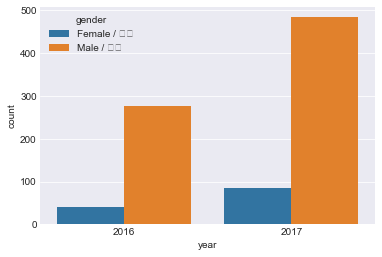

In [217]:
gender_total = pd.DataFrame(merge_for_plot('gender',data_dict),columns=['year','gender'])
#gender_total
sns.countplot(x='year',data = gender_total,hue='gender')


** compare 'nationality' **

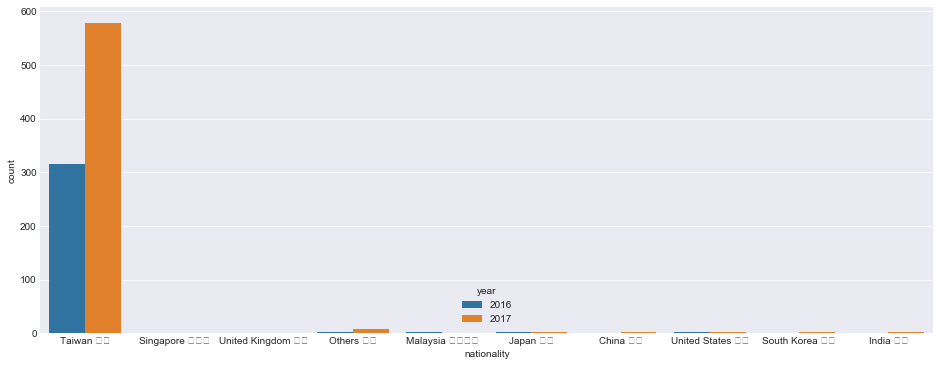

In [221]:
nationality_total = pd.DataFrame(merge_for_plot('nationality',data_dict),columns=['year','nationality'])
plt.subplots(figsize=(16,6))
sns.countplot(x='nationality',data = nationality_total,hue='year')